<center><img src="https://github.com/FASSt-simulation/fasst_simulation_tools/raw/main/images/site-logo.png" width=150 height=150 alt="NGEE-Arctic Logo"/></center>

# Tutorial: *Evaluating ELM fluxes using remote sensing imagery from Google Earth Engine*
This tutorial explores the radiation components of ELM simulations at one of the four [NGEE-Arctic](https://ngee-arctic.ornl.gov/) study sites.


#### ----------------------------------------------------------------------------------------------------------------------

<br>

#### To run this script and generate the resulting ELM plots we need specific Python libraries.  This step loads those required libraries

In [1]:
# setup modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import xarray
from netCDF4 import Dataset 
import os
import cftime
from datetime import datetime as dt
import ipywidgets as widgets
import sys,os,os.path,glob

# spatial modules
import ee
import geemap.colormaps as cm
import geemap.foliumap as geemap
    
import warnings
warnings.filterwarnings('ignore') #don't display warnings

<br>

#### This step creates a temporary folder location to store figures that are created in this notebook.  You can later download these figures to your host computer

In [2]:
## setup output. defined dir or system temp dir
figdir=os.path.expanduser(os.path.join('~','work/figures'))

if not os.path.exists(figdir):
    os.makedirs(figdir)

print(" ")
print("****** Temporary Output Folder ******")
print(figdir)

savefigs = True # True/False

 
****** Temporary Output Folder ******
/home/jovyan/work/figures


<br>

#### To use the GEE layers you need to have a GEE account and authenticate your API before proceeding

In [3]:
##### initialize ee API  - you need to authenticate with GEE and initialize

## Trigger the authentication flow. You only need to do this once while running notebook
ee.Authenticate()

## After inserting the API key initialize GEE
ee.Initialize()

Enter verification code:  4/1ARtbsJq7bt5fp0IpIaslPPqI8aO0-Lj4VNVpR5I-E11YCgc-8PRwMxnOEKc



Successfully saved authorization token.


<br>

#### This step identifies all of the previous ELM cases that are stored in your output location then creates a list to select the output by site

In [4]:
# Create case run output directories

output_rootdir=os.path.expanduser('~')+'/output/cime_run_dirs/'
cases=np.asarray(glob.glob("%s*20TR*" % output_rootdir))
cases=[x.split('/')[-1] for x in cases]
cases_dropdown = widgets.Dropdown(options=cases,
                                description='Choose Case Name:',
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)

<br>

#### Here we create the dropdown menu of ELM output options availible in your output volume

In [6]:
# Show a dropdown menu to select specific case output
# Any cases that have been run in our elmoutput directory will be displayed
# Case names will contain the site codes:
# AK-BEO; AK-CLG; AK-K64G AK-TLG

display(cases_dropdown)

Dropdown(description='Choose Case Name:', index=5, layout=Layout(width='max-content'), options=('OLMT_ens4_AK-…

<br>

#### After selecting which ELM output folder we want to use as our source for simulation output, we can then find all .nc files in the output location

In [7]:
# Get the output nc file options

output_casedir=output_rootdir+cases_dropdown.value+'/run/'
filenames=np.asarray(glob.glob("%s*.elm.h?.*.nc" % output_casedir))
filenames=sorted([x.split('/')[-1] for x in filenames])
if(os.path.exists(output_casedir+'ELM_output.nc')): filenames.insert(0,'ELM_output.nc')

ncfiles_dropdown = widgets.Dropdown(options=filenames,
                                description='Choose Output File:', 
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)

<br>

#### This step displays the .nc file dropdown menu. In most cases you will select "ELM_output.nc" which is the file containing all simulation output years (e.g. 1850-2014)

In [8]:
# Display the output nc file options - in most cases you will select ELM_output.nc

display(ncfiles_dropdown)

Dropdown(description='Choose Output File:', layout=Layout(width='max-content'), options=('ELM_output.nc', 'OLM…

<br>

#### This step uses the xarray package to load the ELM output so that we can analyze the results and generate plots

In [9]:
# Load model output data into xarray format. 
# squeeze removes an empty grid cell dimension assuming this is a single point run
output_file=output_casedir+ncfiles_dropdown.value
elm_output=xarray.open_dataset(output_file).squeeze()
temptime = elm_output.indexes['time'].to_datetimeindex()
elm_output['time'] = temptime

<br>

#### We can quickly display a subset of the nc file metadata here using the print() command

#### Note that on the left is the name of the data dimension or variable and on the right shows the data type and other metadata

In [10]:
# show the contents of elm_output

print(elm_output)

<xarray.Dataset>
Dimensions:                   (levgrnd: 15, levlak: 10, levdcmp: 15,
                               time: 60226, hist_interval: 2, ltype: 9,
                               natpft: 17)
Coordinates:
  * levgrnd                   (levgrnd) float32 0.007101 0.02792 ... 21.33 35.18
  * levlak                    (levlak) float32 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp                   (levdcmp) float32 0.007101 0.02792 ... 21.33 35.18
  * time                      (time) datetime64[ns] 1850-01-01 ... 2015-01-01
Dimensions without coordinates: hist_interval, ltype, natpft
Data variables: (12/562)
    mcdate                    (time) int32 ...
    mcsec                     (time) int32 ...
    mdcur                     (time) int32 ...
    mscur                     (time) int32 ...
    nstep                     (time) int32 ...
    time_bounds               (time, hist_interval) object ...
    ...                        ...
    leaf_npimbalance          (time) float32 .

<br>

#### Lets get the specific lat/long of the model simulation to use with extracting remote sensing data

In [11]:
print(elm_output['lon'],elm_output['lat'])
lat=elm_output['lat'].values.item()
lon=elm_output['lon'].values.item()
print(lat,lon)

<xarray.DataArray 'lon' ()>
array(-165.75)
Attributes:
    long_name:  coordinate longitude
    units:      degrees_east <xarray.DataArray 'lat' ()>
array(65.75)
Attributes:
    long_name:  coordinate latitude
    units:      degrees_north
65.75 -165.75


<br>

#### You will see the lat/long location is inaccurate given the resolution of the global ELM inputs. Instead lets set a more accurate location of the study site based on the list below.  Copy and paste the updated lat and long values below based on which site you are analyzing

AK-BEOG (Utqiagvik): 71.281054, -156.615273 <br>
AK-CLG (Council): 64.854151, -163.726455 <br>
AK-K64G (Kougarok): 65.163724, -164.817472 <br>
AK-TLG (Teller): 64.732523, -165.952788 <br>

In [12]:
# set the desired lat/long here (copy and paste the lat/longs)
lat=64.732523
lon=-165.952788

<br>

#### Lets get some imagery from GEE. In this case we will make an NDVI map with the site location shown as a black dot

In [13]:
##### Get Landsat 8 NDVI max data
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_NDVI').filterDate('2019-07-01', '2019-09-05')
l8_ndvi = l8.select('NDVI');

# Composite and drop values == 1
l8_maxval_ndvi_composite = l8_ndvi.max()
l8mask = l8_maxval_ndvi_composite.lt(1)
l8_maxval_ndvi_composite = l8_maxval_ndvi_composite.updateMask(l8mask)

In [14]:
# Create an NDVI map w/ the site location

# site lat/long
point = ee.Geometry.Point(lon, lat);

ndvi_palette = cm.palettes.viridis
ndviViz = {'min': 0.0, 'max': 0.9, 'palette': ndvi_palette, 'opacity': 1}
l8_ndvi_map = geemap.Map(center=[lat,lon], zoom=10);
l8_ndvi_map.addLayer(l8_maxval_ndvi_composite, ndviViz, 'Max NDVI')
l8_ndvi_map.addLayer(point,{'color': 'black'},'Geometry [black]: point');
l8_ndvi_map.add_colorbar(vis_params=ndviViz, label='Landsat 8 NDVI (-)')
l8_ndvi_map

<br>

#### Before we move on, lets setup a function to extract a timeseries dataset from a specific lat/long location

In [15]:
def extract_time_series(lat, lon, start, end, product_name, band_name, sf):

    # Set up point geometry
    point = ee.Geometry.Point(lon, lat)

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product_name)\
        .filterDate(start, end)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = ee.Image(image)
        projection = im.projection().getInfo()['crs']

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
        .reduceRegion(ee.Reducer.first(),
                      point,
                      1,
                      crs=projection)\
        .get(band_name)
        
        store.append(data.getInfo())

    # Scale the returned data based on scale factor
    store = [x * sf if isinstance(x, int) else np.nan for x in store]

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df

<br>

#### Lets extract a timeseries of LAI data for the study site

In [16]:
# Run the extract function
latitude = lat
longitude = lon
start_date = '2010-01-01'
end_date = '2014-12-31'
product = 'MODIS/061/MOD15A2H' 
#LAI scale factor: 0.1
#FPAR scale factor: 0.01
#https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD15A2H

# Extract data and obtain pd.DataFrame
band = 'Lai_500m'
scale_factor = 0.1
modis_lai = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

band = 'Fpar_500m'
scale_factor = 0.01
modis_fpar = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)


# !!! should also extract SDs and plot as a shaded region
#FparStdDev_500m
#Standard deviation of FPAR

#LaiStdDev_500m
#Standard deviation of LAI

<br>

#### Lets look at the data that is returned from the extract function

In [17]:
modis_lai.head()

,Lai_500m
2010-01-01,25.5
2010-01-09,0.4
2010-01-17,0.6
2010-01-25,0.0
2010-02-02,0.0


In [18]:
modis_fpar.head()

,Fpar_500m
2010-01-01,2.55
2010-01-09,0.19
2010-01-17,0.28
2010-01-25,0.00
2010-02-02,0.00


<br>

#### Lets plot the MODIS LAI and FPAR datasets for the selected years

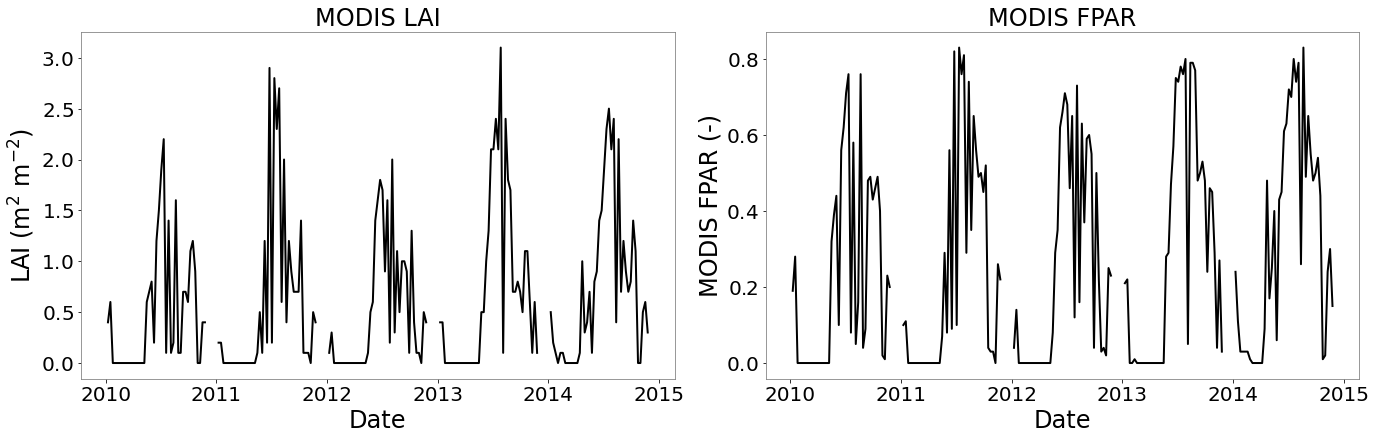

In [19]:
#### Plot the LAI and FPAR data

fig = plt.figure(figsize=(19, 6))
ax = fig.add_subplot(1, 2, 1)
modis_lai.where(modis_lai['Lai_500m']<12).plot(ax=ax, kind='line',linewidth=2,color='black')
ax.get_legend().remove()
plt.xticks(fontsize=20, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=20, rotation=0)
ax.set_title('MODIS LAI', size=24)
ax.set_xlabel('Date', size=24)
ax.set_ylabel('LAI (m$^{2}$ m$^{-2}$)', size=24)

ax = fig.add_subplot(1, 2, 2)
modis_fpar.where(modis_fpar['Fpar_500m']<1).plot(ax=ax, kind='line',linewidth=2,color='black')
ax.get_legend().remove()
plt.xticks(fontsize=20, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=20, rotation=0)
ax.set_title('MODIS FPAR', size=24)
ax.set_xlabel('Date', size=24)
ax.set_ylabel('MODIS FPAR (-)', size=24)
if savefigs:
    plt.savefig(os.path.join(figdir,'MODIS_LAI_FPAR.pdf'))
    plt.savefig(os.path.join(figdir,'MODIS_LAI_FPAR.png'))
plt.show()

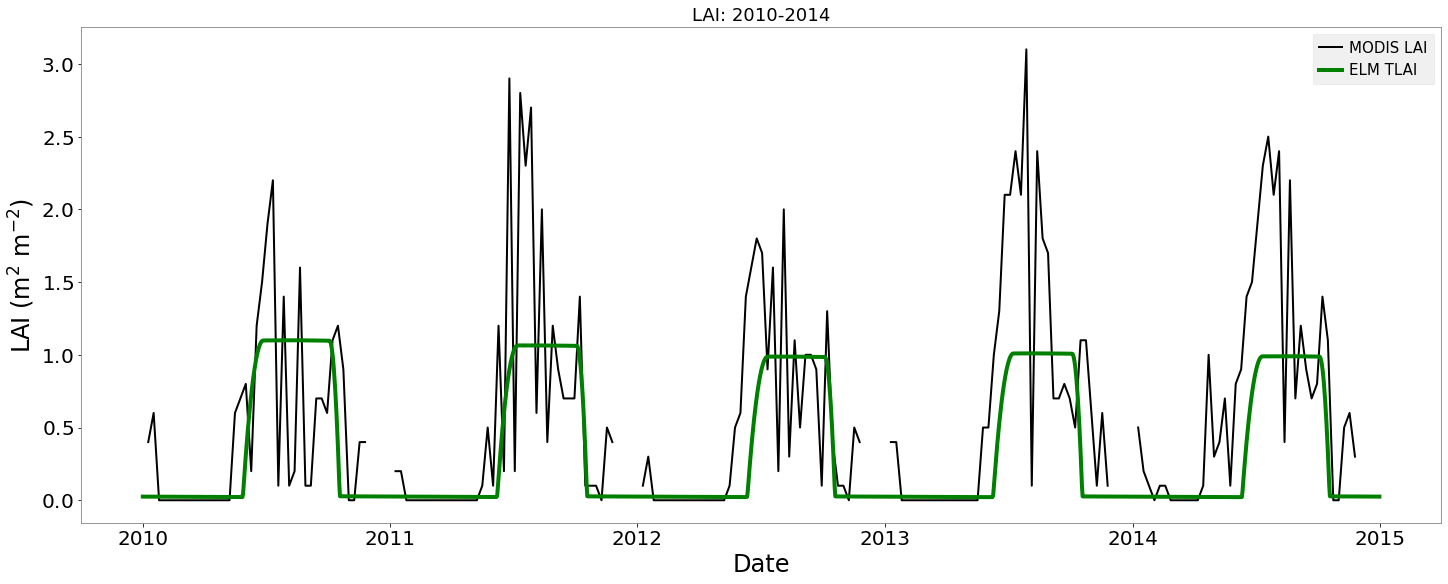

In [20]:
timerange=slice('2010-01-01','2014-12-31')

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1)
modis_lai['Lai_500m'].where(modis_lai['Lai_500m']<12).plot(ax=ax,linestyle='-',linewidth=2,color='black',label='MODIS LAI')
elm_output['TLAI'].sel(time=timerange).plot(ax=ax, linestyle='-',linewidth=4,color='green',label='ELM TLAI')
ax.legend(fontsize=15)
plt.xticks(fontsize=20, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=20, rotation=0)
ax.set_title('LAI: 2010-2014', size=18)
ax.set_xlabel('Date', size=24)
ax.set_ylabel('LAI (m$^{2}$ m$^{-2}$)', size=24)
if savefigs:
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_LAI_2.pdf'))
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_LAI_2.png'))
plt.show()

<br>

#### Lets extract a timeseries of Gross Primary Productivity (GPP) data for the study site

In [21]:
# Run the extract function
latitude = lat
longitude = lon
start_date = '2010-01-01'
end_date = '2014-12-31'
product = 'MODIS/006/MOD17A2H' 

# Extract data and obtain pd.DataFrame
band = 'Gpp'
scale_factor = 0.0001
modis_gpp = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

<br>

#### Now we can create a figure to compare ELM GPP vs MODIS GPP retrievals for the study site

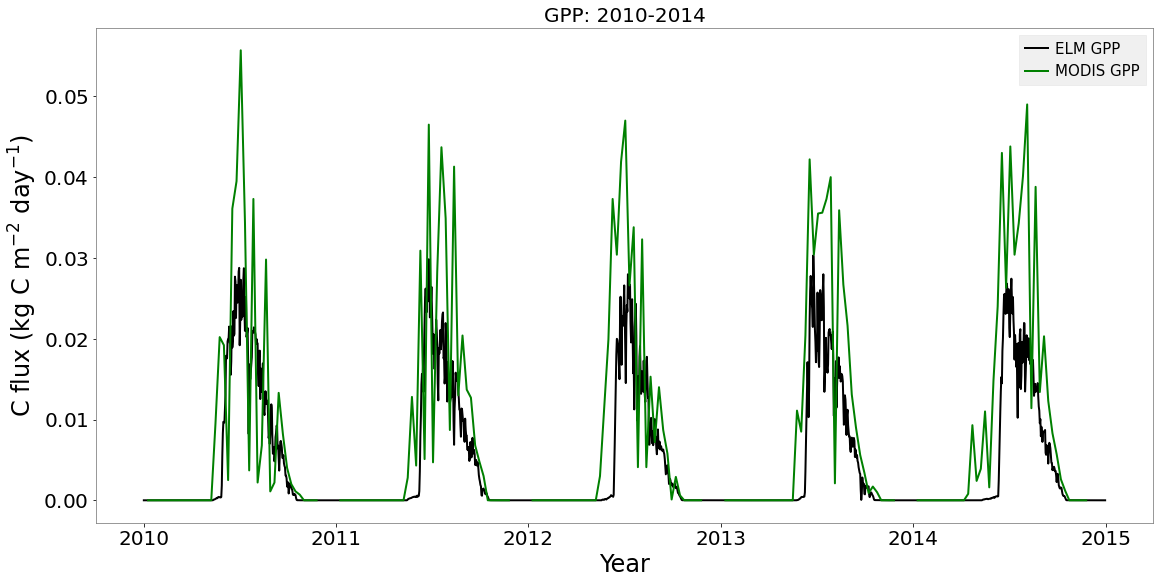

In [27]:
timerange=slice('2010-01-01','2014-12-31')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
# need to convert ELM from gC/m^2/s to kgC/m2/8days
tempdata = (elm_output['GPP']*0.001)*86400*8
tempdata.sel(time=timerange).plot(ax=ax, linestyle='-',linewidth=2,color='black',label='ELM GPP')
modis_gpp['Gpp'].plot(ax=ax,linestyle='-',linewidth=2,color='green',label='MODIS GPP')
ax.legend(fontsize=15)
plt.xticks(fontsize=20, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=20, rotation=0)
ax.set_title('GPP: 2010-2014', size=20)
ax.set_xlabel('Year', size=24)
ax.set_ylabel('C flux (kg C m$^{-2}$ day$^{-1}$)', size=24)
if savefigs:
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_GPP.pdf'))
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_GPP.png'))
plt.show()

<br>

#### We can also extract a timeseries of Net Primary Productivity (NPP) data for the study site

In [31]:
# Run the extract function
latitude = lat
longitude = lon
start_date = '2000-01-01'
end_date = '2014-12-31'
product = 'MODIS/006/MOD17A3HGF' 

# Extract data and obtain pd.DataFrame
band = 'Npp'
scale_factor = 0.0001
modis_npp = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

In [32]:
print(modis_npp['Npp'])

2000-02-18    0.2078
2001-01-01    0.1766
2002-01-01    0.2950
2003-01-01    0.2585
2004-01-01    0.3192
2005-01-01    0.3110
2006-01-01    0.2034
2007-01-01    0.3132
2008-01-01    0.2443
2009-01-01    0.2424
2010-01-01    0.2755
2011-01-01    0.2556
2012-01-01    0.2214
2013-01-01    0.2299
2014-01-01    0.2743
Name: Npp, dtype: float64


<br>

#### Before we compare ELM to the MODIS NPP product, we will need to scale the units to match. As you can see below, NPP in ELM is currently a flux (gC/m2/2)

In [54]:
elm_output['NPP']

<xarray.DataArray 'NPP' (time: 60226)>
array([-3.019482e-07, -3.915156e-07, -4.198802e-07, ..., -5.524325e-07,
       -6.211362e-07, -6.049114e-07], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-01-02 ... 2015-01-01
Attributes:
    long_name:     net primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

<br>

#### Here we can select out an overlapping date range and then convert ELM from a flux to a pool

In [55]:
# subset and convert from gC/m2/s to kgC/m2/day
dataset_sub = elm_output.sel(time=slice('1999', '2013'))
# calculate annual sum (i.e. annual total NPP)
elm_annual_npp = (dataset_sub['NPP']*0.001*86400).resample(time='Y').sum('time')

<br>

#### Now we can create the figure

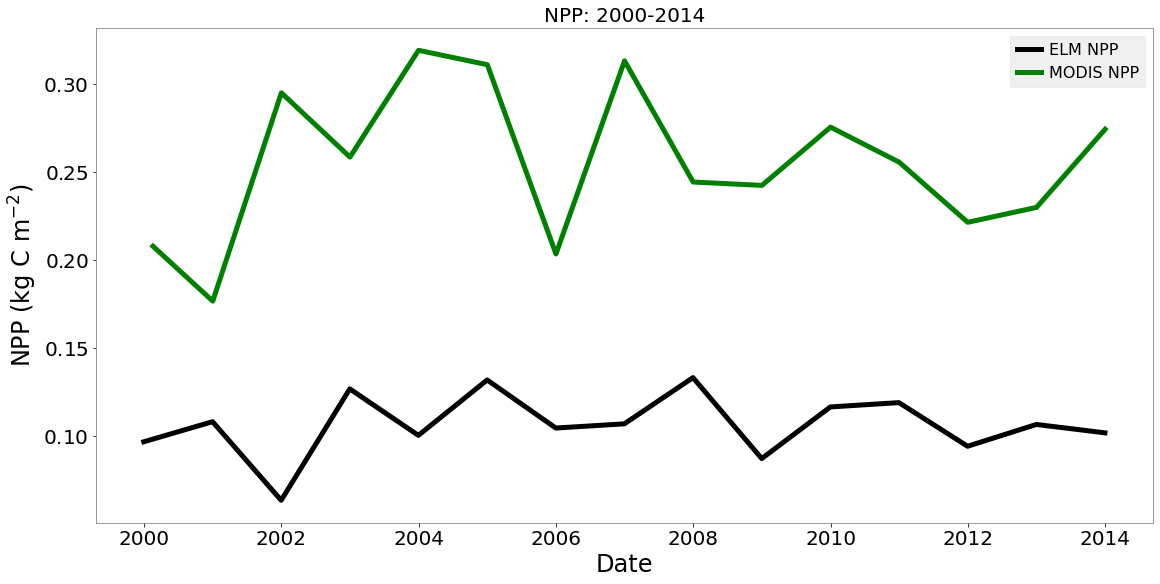

In [56]:
# Draw the comparison plot between MODIS and ELM annual NPP
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
elm_annual_npp.plot(ax=ax, linestyle='-',linewidth=5,color='black',label='ELM NPP')
modis_npp['Npp'].plot(ax=ax,linestyle='-',linewidth=5,color='green',label='MODIS NPP')
ax.legend(fontsize=16)
plt.xticks(fontsize=20, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=20, rotation=0)
ax.set_title('NPP: 2000-2014', size=20)
ax.set_xlabel('Date', size=24)
ax.set_ylabel('NPP (kg C m$^{-2}$)', size=24)
if savefigs:
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_Annual_NPP.pdf'))
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_Annual_NPP.png'))
plt.show()

<br>

#### Create a X-Y scatter plot of the annual NPP comparison between MODIS and ELM

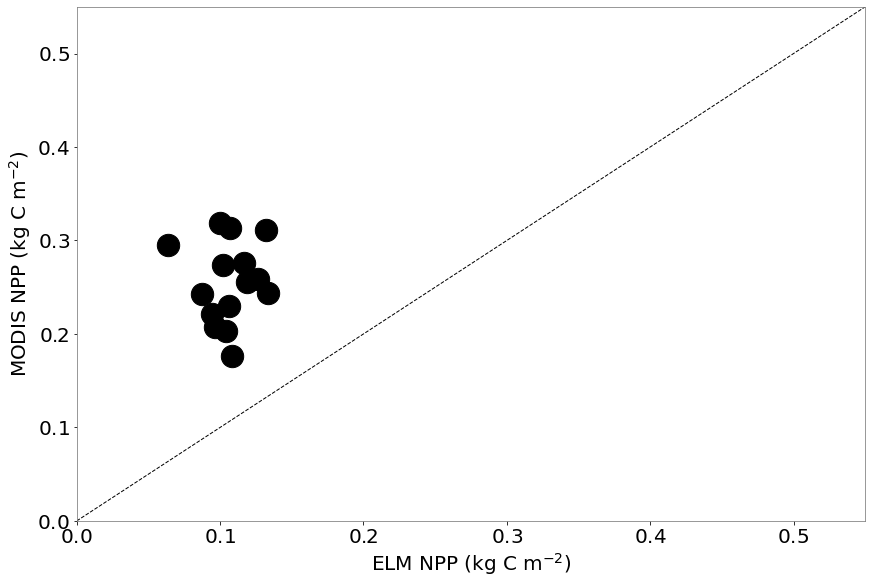

In [50]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(elm_annual_npp, modis_npp['Npp'], c="black", s=500)
ax.set_ylim([0.0, 0.55])
ax.set_xlim([0.0, 0.55])
plt.xticks(fontsize=20, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=20, rotation=0)
ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle='--', color='black')
ax.set_xlabel('ELM NPP (kg C m$^{-2}$)', size=20)
ax.set_ylabel('MODIS NPP (kg C m$^{-2}$)', size=20)
if savefigs:
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_Annual_NPP_scatter.pdf'))
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_Annual_NPP_scatter.png'))
plt.show()

<br>

#### We can also compare the annual NPP distributions in a histogram plot

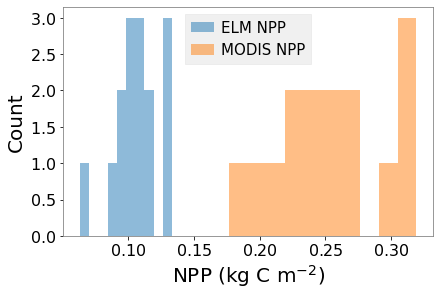

In [67]:
plt.hist(elm_annual_npp, alpha=0.5, label='ELM NPP', histtype='bar')
n, bins, patches = plt.hist(modis_npp['Npp'], alpha=0.5, label='MODIS NPP', histtype='bar')
plt.legend(fontsize=15)
plt.xlabel('NPP (kg C m$^{-2}$)', size=20)
plt.ylabel('Count', size=20)
plt.xticks(fontsize=16, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=16, rotation=0)
if savefigs:
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_Annual_NPP_histogram.pdf'))
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_Annual_NPP_histogram.png'))
plt.show()

<br>

#### Using GEDI lidar derived above-ground biomass, we can compare annual biomass carbon pools with ELM 

In [68]:
print(elm_output['TOTVEGC_ABG'])

<xarray.DataArray 'TOTVEGC_ABG' (time: 60226)>
array([70.48643 , 70.4837  , 70.47847 , ..., 98.72645 , 98.71879 , 98.711136],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-01-02 ... 2015-01-01
Attributes:
    long_name:     total aboveground vegetation carbon, excluding cpool
    units:         gC/m^2
    cell_methods:  time: mean


In [96]:
#elm_annual_agb_mg_ha = (dataset_sub['TOTVEGC_ABG']*0.01).resample(time='Y').sum('time')
#elm_annual_agb_mg_ha
#elm_annual_agb_tonne_ha = (dataset_sub['TOTVEGC_ABG']*100/24).resample(time='Y').sum('time')
#elm_annual_agb_tonne_ha

<xarray.DataArray 'TOTVEGC_ABG' (time: 15)>
array([142097.55, 147806.73, 136964.89, 140784.4 , 153461.25, 152794.19,
       161491.47, 157730.64, 163968.22, 163899.08, 159348.06, 166308.6 ,
       160131.56, 156321.66, 156993.03], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1999-12-31 2000-12-31 ... 2013-12-31

In [80]:
#l4b = ee.Image('LARSE/GEDI/GEDI04_B_002')
WCMC = ee.Image('WCMC/biomass_carbon_density/v1_0/2010');

In [86]:
point = ee.Geometry.Point(lon, lat)


region = ee.Geometry.Point([lon, lat]).buffer(10)


ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Geometry.buffer",
    "arguments": {
      "distance": {
        "constantValue": 10
      },
      "geometry": {
        "functionInvocationValue": {
          "functionName": "GeometryConstructors.Point",
          "arguments": {
            "coordinates": {
              "constantValue": [
                -165.952788,
                64.732523
              ]
            }
          }
        }
      }
    }
  }
})

In [93]:
#data = l4b.select('MU').reduceRegion(ee.Reducer.first(),point,1)
data = WCMC.select('carbon_tonnes_per_ha').reduceRegion(ee.Reducer.first(),point,1)
data.getInfo()

{'carbon_tonnes_per_ha': 0.4444444477558136}

In [90]:
#random_points = geemap.random_sampling(WCMC, region, numPixels=5)
#df = geemap.ee_to_pandas(random_points)
#df

Exception: Element.propertyNames: Parameter 'element' is required.

<br>

#### Download MODIS albedo (direct, diffuse, VIS and NIR)

In [ ]:
# Run the extract function
latitude = lat
longitude = lon
start_date = '2012-01-01'
end_date = '2012-12-31'
product = 'MODIS/006/MCD43A3' 

# Extract data and obtain pd.DataFrame
band = 'Albedo_BSA_vis'
scale_factor = 0.001
modis_bsa_vis = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

band = 'Albedo_BSA_nir'
scale_factor = 0.001
modis_bsa_nir = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

In [ ]:
# Calculate direct NIR albedo

# Calculate diffuse NIR albedo

# Calculate direct VIS albedo
elm_output['BSA_VIS'] = elm_output['FSRVD']/elm_output['FSDSVD'].where(elm_output['FSDSVD']>0)
elm_output['BSA_VIS'].attrs['units'] = 'unitless'
elm_output['BSA_VIS'].attrs['long_name'] = 'Black Sky Visible Albedo'

# Calculate all-sky albedo and plot the timeseries
elm_output['ASA'] = elm_output['FSR']/elm_output['FSDS'].where(elm_output['FSDS']>0)
elm_output['ASA'].attrs['units'] = 'unitless'
elm_output['ASA'].attrs['long_name'] = 'All sky albedo'


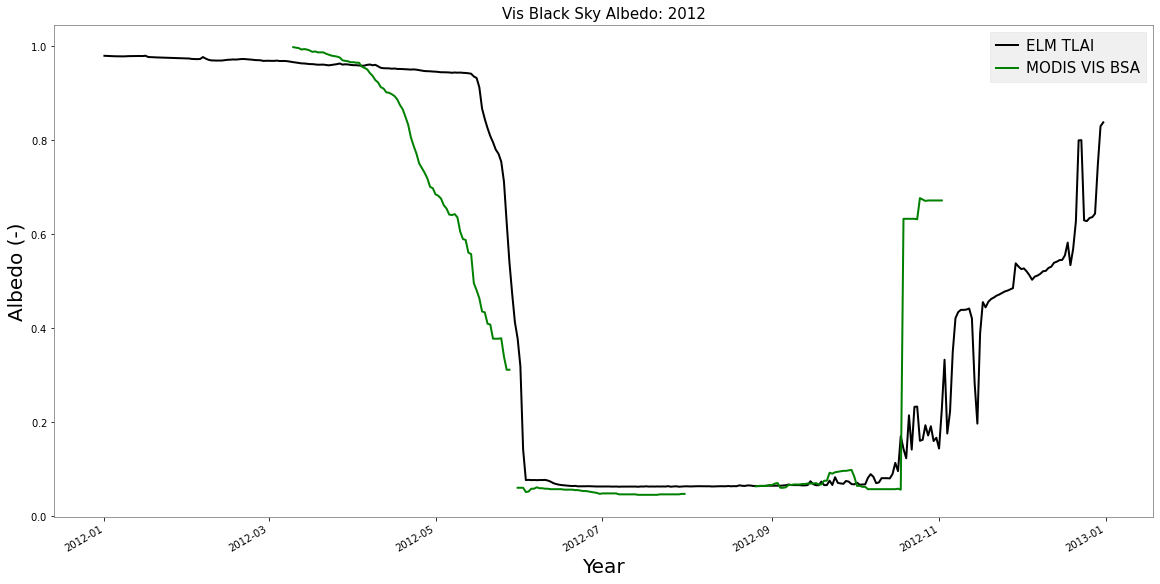

In [80]:
timerange=slice('2012-01-01','2012-12-31')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
elm_output['BSA_VIS'].sel(time=timerange).plot(ax=ax, linestyle='-',linewidth=2.5,color='black',label='ELM TLAI')
modis_bsa_vis['Albedo_BSA_vis'].plot(ax=ax,linestyle='-',linewidth=2.5,color='green',label='MODIS VIS BSA')
ax.legend(fontsize=17)
plt.xticks(fontsize=20, rotation=0, horizontalalignment='center')
plt.yticks(fontsize=20, rotation=0)
ax.set_title('Vis Black Sky Albedo: 2012', size=18)
ax.set_xlabel('Year', size=24)
ax.set_ylabel('BSVIS Albedo (-)', size=24)
if savefigs:
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_BSA_VIS.pdf'))
    plt.savefig(os.path.join(figdir,'ELM_vs_MODIS_BSA_VIS.png'))
plt.show()

<br>

#### Lets calculate Albedo and compare with MODIS Albedo

<br>

<br>

### Comparing with SMAP soil moisture data. Unfortunetaly the time frames dont match but we can still use SMAP data to evaluate averate ELM profiles

In [70]:
# Run the extract function
latitude = lat
longitude = lon
start_date = '2015-01-01'
end_date = '2020-12-31'
product = 'NASA_USDA/HSL/SMAP10KM_soil_moisture' 

# Extract data and obtain pd.DataFrame
band = 'smp'
scale_factor = 1.0
smap_smp = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

band = 'ssm'
scale_factor = 1.0
smap_ssm = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

In [71]:
smap_smp.head()

,smp
2015-04-02 12:00:00,NaN
2015-04-05 12:00:00,NaN
2015-04-08 12:00:00,NaN
2015-04-11 12:00:00,NaN
2015-04-14 12:00:00,NaN


In [69]:
min(smap_smp['smp'])
max(smap_smp['smp'])

TypeError: 'Series' object cannot be interpreted as an integer

In [ ]:
min(smap_ssm['ssm'])
max(smap_ssm['ssm'])

Text(0.5, 0, 'Year')

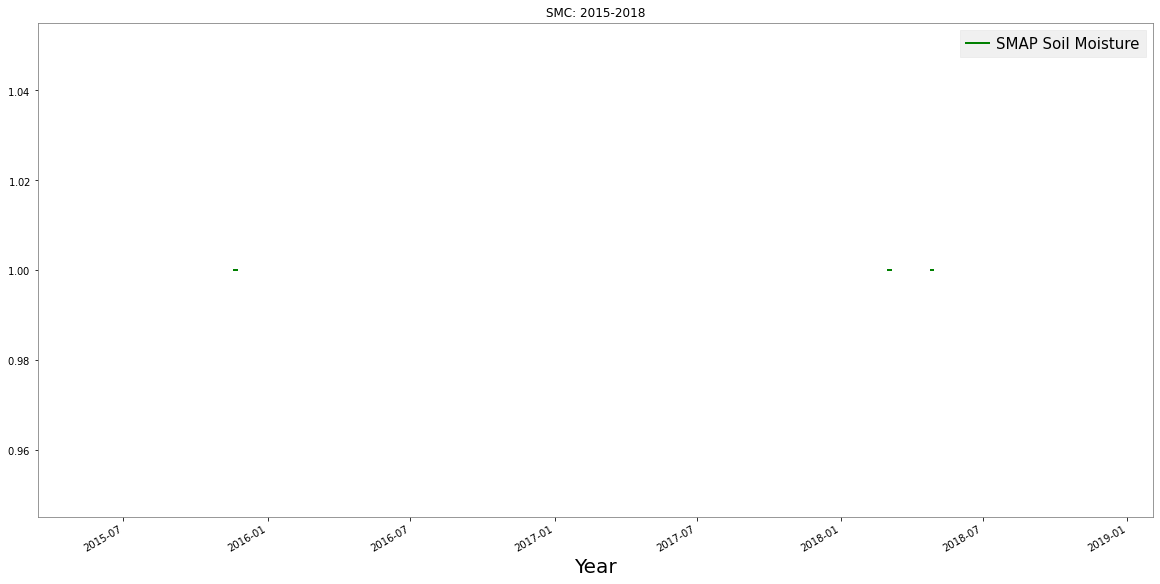

In [63]:
timerange=slice('2015-01-01','2020-12-31')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
smap_smp['smp'].plot(ax=ax,linestyle='-',linewidth=2,color='green',label='SMAP Soil Moisture')
ax.legend(fontsize=15)
ax.set_title('SMC: 2015-2018')
ax.set_xlabel('Year', size=20)
#ax.set_ylabel('C flux (kg C m$^{-2}$ day$^{-1}$)', size=20)




FLDAS dataset?
#https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001

In [96]:
# Run the extract function
latitude = lat
longitude = lon
start_date = '2010-01-01'
end_date = '2014-12-31'
product = 'CAS/IGSNRR/PML/V2_v017' 
#LAI scale factor: 0.1
#FPAR scale factor: 0.01
#https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD15A2H

# Extract data and obtain pd.DataFrame
band = 'GPP'
scale_factor = 1.0
pml_gpp = extract_time_series(latitude,longitude,start_date,end_date,product,band,scale_factor)

In [99]:
pml_gpp.head()
pml_gpp.max()
#pml_gpp.min()
#pml_gpp.mean()

GPP    3.0
dtype: float64

In [100]:
pml_gpp

,GPP
2010-01-01,NaN
2010-01-09,NaN
2010-01-17,NaN
2010-01-25,0.0
2010-02-02,0.0
...,...
2014-11-25,NaN
2014-12-03,NaN
2014-12-11,0.0
2014-12-19,0.0


Text(0, 0.5, 'GPP (gC/m2/day)')

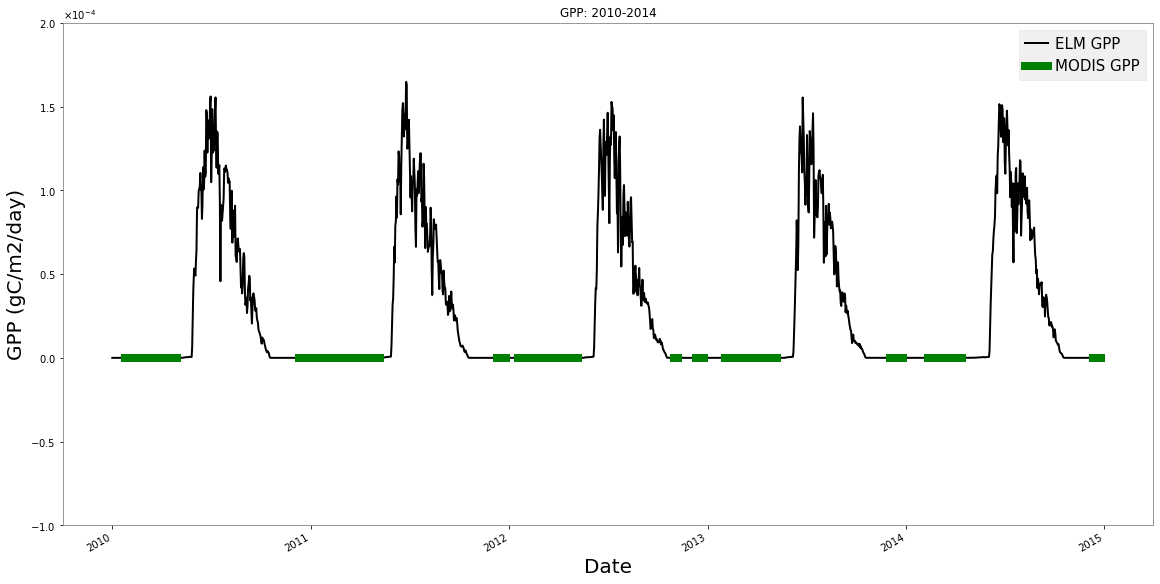

In [101]:
timerange=slice('2010-01-01','2014-12-31')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
elm_output['GPP'].sel(time=timerange).plot(ax=ax, linestyle='-',linewidth=2,color='black',label='ELM GPP')
pml_gpp['GPP'].plot(ax=ax,linestyle='-',linewidth=8,color='green',label='MODIS GPP')
ax.set_ylim([-0.0001, 0.0002])
ax.legend(fontsize=15)
ax.set_title('GPP: 2010-2014')
ax.set_xlabel('Date', size=20)
ax.set_ylabel('GPP (gC/m2/day)', size=20)


# need to convert ELM from gC/m^2/s to kgC/m2/d

Text(0, 0.5, 'GPP (gC/m2/day)')

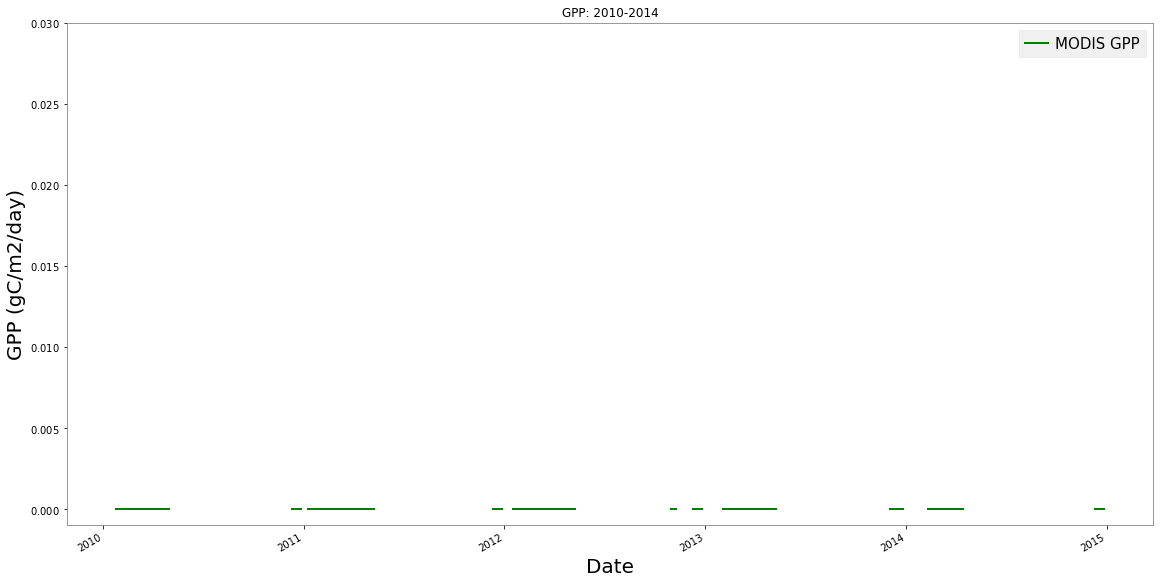

In [82]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
pml_gpp['GPP'].plot(ax=ax,linestyle='-',linewidth=2,color='green',label='MODIS GPP')
ax.set_ylim([-0.001, 0.03])
ax.legend(fontsize=15)
ax.set_title('GPP: 2010-2014')
ax.set_xlabel('Date', size=20)
ax.set_ylabel('GPP (gC/m2/day)', size=20)

In [83]:
pml_gpp['GPP']

2010-01-01    NaN
2010-01-09    NaN
2010-01-17    NaN
2010-01-25    0.0
2010-02-02    0.0
             ... 
2014-11-25    NaN
2014-12-03    NaN
2014-12-11    0.0
2014-12-19    0.0
2014-12-27    0.0
Name: GPP, Length: 230, dtype: float64

In [118]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xarray.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xarray.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [122]:
dataset_sub = elm_output.sel(time=slice('2000', '2014'))
annual_avg = weighted_temporal_mean(dataset_sub, 'NPP')
annual_avg

<xarray.DataArray (time: 15)>
array([9.44654896e-06, 8.75328326e-06, 1.42922571e-05, 8.81715324e-06,
       1.58128860e-05, 1.02980512e-05, 1.13363104e-05, 1.37847453e-05,
       9.98892507e-06, 1.31093021e-05, 1.04825493e-05, 1.19684708e-05,
       9.28896505e-06, 1.18112444e-05, 1.17678350e-05])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2014-01-01